In [4]:
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode, iplot
# from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

#init_notebook_mode(connected=True)
RANDOM_SEED = 123


In [4]:
IMG_PATH = 'augmented_data/'

In [5]:
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)


In [10]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:06<00:00,  3.37s/it]
<ipython-input-10-bdf82dc0d3a7>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X)
  0%|          | 0/2 [00:00<?, ?it/s]

1642 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

412 images loaded from VAL/ directory.


In [16]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [17]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<ipython-input-16-65876982ba26>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(set_new)


In [13]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [18]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [11]:
# Data Augmentation
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
TEST_DIR = 'TEST_CROP/'

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [13]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1642 images belonging to 2 classes.
Found 412 images belonging to 2 classes.


In [3]:
IMG_SIZE = (224,224)
#vgg19_weight_path = 'keras-pretrained-models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG19(
    #weights=vgg16_weight_path,
    #weights="imagenet",
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input
import os
import sys
import random
import warnings
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras


from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot 
from numpy import expand_dims

In [6]:
# Model with VGG16(Accuracy on validation set of 90%)
NUM_CLASSES = 1

vgg19 = Sequential()
vgg19.add(vgg)
vgg19.add(layers.Dropout(0.3))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg19.layers[0].trainable = False

vgg19.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [30]:
# Start the training on vgg16
import time

start = time.time()

filepath = "checkpoint.h5"

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=filepath,save_weights_only=True,verbose=1)

vgg19_history = vgg19.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=20,
    callbacks=[cp_callback]
)

end = time.time()
print(end - start)

#Apply Checkpoint
# from keras.callbacks import ModelCheckpoint 
# filepath = "checkpoint.h5"
# checkpoint = ModelCheckpoint(filepath , monitor='val_accuracy', verbose =1,
#                             save_best_only =True, mode = 'max')

# callbacks_list = [checkpoint]

Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 4.6199 - accuracy: 0.5906
Epoch 00001: saving model to checkpoint.h5
50/50 [==============================] - 570s 11s/step - loss: 4.6199 - accuracy: 0.5906 - val_loss: 2.4218 - val_accuracy: 0.7281
Epoch 2/40
50/50 [==============================] - ETA: 0s - loss: 3.4906 - accuracy: 0.6698
Epoch 00002: saving model to checkpoint.h5
50/50 [==============================] - 571s 11s/step - loss: 3.4906 - accuracy: 0.6698 - val_loss: 1.8279 - val_accuracy: 0.7781
Epoch 3/40
50/50 [==============================] - ETA: 0s - loss: 3.1758 - accuracy: 0.7186
Epoch 00003: saving model to checkpoint.h5
50/50 [==============================] - 573s 11s/step - loss: 3.1758 - accuracy: 0.7186 - val_loss: 1.5937 - val_accuracy: 0.8156
Epoch 4/40
50/50 [==============================] - ETA: 0s - loss: 2.8127 - accuracy: 0.7307
Epoch 00004: saving model to checkpoint.h5
50/50 [==============================] - 573s 11s/step - lo

50/50 [==============================] - 571s 11s/step - loss: 0.7591 - accuracy: 0.9106 - val_loss: 0.3329 - val_accuracy: 0.9281
Epoch 32/40
50/50 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.9056
Epoch 00032: saving model to checkpoint.h5
50/50 [==============================] - 571s 11s/step - loss: 0.7634 - accuracy: 0.9056 - val_loss: 0.5610 - val_accuracy: 0.9250
Epoch 33/40
50/50 [==============================] - ETA: 0s - loss: 0.8014 - accuracy: 0.9005
Epoch 00033: saving model to checkpoint.h5
50/50 [==============================] - 571s 11s/step - loss: 0.8014 - accuracy: 0.9005 - val_loss: 0.1970 - val_accuracy: 0.9594
Epoch 34/40
50/50 [==============================] - ETA: 0s - loss: 0.6111 - accuracy: 0.9138
Epoch 00034: saving model to checkpoint.h5
50/50 [==============================] - 572s 11s/step - loss: 0.6111 - accuracy: 0.9138 - val_loss: 0.3606 - val_accuracy: 0.9312
Epoch 35/40
50/50 [==============================] - ETA: 0s -

In [31]:
print(vgg19_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


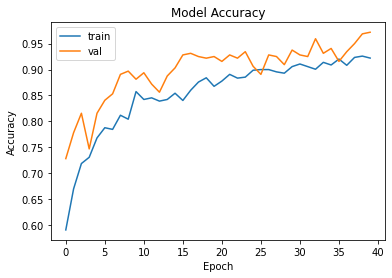

In [32]:
import keras
from matplotlib import pyplot as plt
#history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=40, batch_size=50)
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

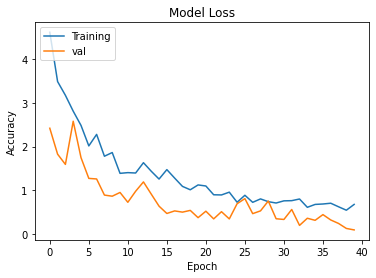

In [33]:
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'val'], loc='upper left')
plt.show()

In [35]:
vgg19.evaluate(X_test_prep,y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0084 - accuracy: 1.0000


[0.008400882594287395, 1.0]

In [44]:
y_pred = vgg19.predict(X_test_prep)

In [45]:
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

In [46]:
y_pred

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [19]:
vgg19.evaluate(X_val_prep,y_val)

13/13 [==============================] - 144s 10s/step - loss: 0.1826 - accuracy: 0.9572


[0.1497439444065094, 0.9660193920135498]

In [8]:
vgg19.load_weights('checkpoint.h5')

In [20]:
y_pred = vgg19.predict(X_val_prep)

In [23]:
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

In [24]:
cm = confusion_matrix(y_val,y_pred)

In [25]:
cm

array([[183,  13],
       [  1, 215]])

AttributeError: 'list' object has no attribute 'max'

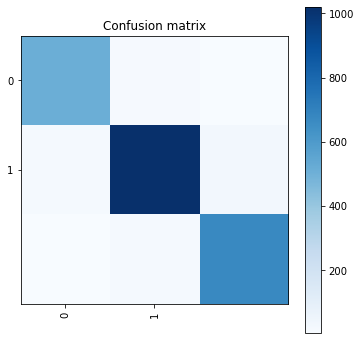

In [8]:
plot_confusion_matrix(cm,[0,1])

In [1]:
from sklearn.metrics import precision_recall_fscore_support

In [28]:
precision_recall_fscore_support(y_val, y_pred, average='macro')

(0.9687738367658276, 0.9645219198790627, 0.9658131816026554, None)

In [30]:
precision_recall_fscore_support(y_val, y_pred, average='micro')

(0.9660194174757282, 0.9660194174757282, 0.9660194174757282, None)

In [31]:
precision_recall_fscore_support(y_val, y_pred, average='weighted')

(0.9675218279976007, 0.9660194174757282, 0.9659420790233259, None)

In [9]:
cm = [[512,15,4],[18,1021,30],[4,18,675]]
cm = np.array(cm)

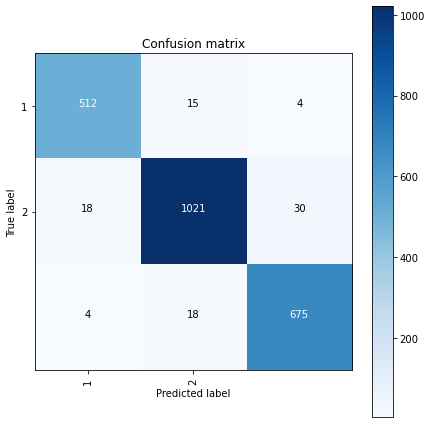

In [10]:
plot_confusion_matrix(cm,[1,2])